In [1]:
from copy import deepcopy
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

In [4]:
class ReplayBuffer():
    def __init__(self, mem_size, batch_size, input_dims):
        self.mem_size = mem_size
        self.mem_centr = 0
        self.batch_size = batch_size

        self.state_memory = np.zeros(
            (self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros(
            (self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transitions(self, state, action, reward, new_state, done):
        index = self.mem_centr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)

        self.mem_centr = self.mem_centr + 1

    def is_sampleable(self):
        if self.mem_centr >= self.batch_size:
            return True
        else:
            return False

    def sample_buffer(self):
        if not(self.is_sampleable()):
            return []
        else:
            batch = np.random.choice(
                self.mem_size, self.batch_size, replace=False)

            states = self.state_memory[batch]
            new_states = self.new_state_memory[batch]
            actions = self.action_memory[batch]
            rewards = self.reward_memory[batch]
            terminals = self.terminal_memory[batch]

            return states, new_states, actions, rewards, terminals

In [5]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dims, n_actions):
        
        super(NeuralNetwork, self).__init__()
        
        self.layer1 = nn.Linear(input_dims[0], 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, n_actions)
        
    def forward(self, x):
        
        l1 = self.layer1(x)
        l1 = F.relu(l1)
        l2 = self.layer2(l1)
        l2 = F.relu(l2)
        l3 = self.layer3(l2)
        
        output = l3
        
        return output

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Force Use a Device
#device = 'cuda' #for GPU
#device = 'cpu'  #for CPU

print(f'Using {device} device')

Using cuda device


In [7]:
class Agent():
    def __init__(self, n_actions, input_dims,
                 lr=1e-4, gamma=0.9, mem_size=128, batch_size=64,
                  epsilon_decay=0.995, target_update_frequency=256):

        self.n_actions = n_actions
        self.input_dims = input_dims

        self.gamma = gamma
        self.epsilon_decay = epsilon_decay

        self.batch_size = batch_size
        self.target_update_freq = target_update_frequency

        self.policy_network = NeuralNetwork(input_dims=input_dims, n_actions=n_actions).to(device)
        self.target_network = deepcopy(self.policy_network)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr = lr)

        self.replay_mem = ReplayBuffer(
            mem_size=mem_size, batch_size=batch_size, input_dims=input_dims)

        self.epsilon = 1

    def choose_action(self, obs):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            obs_T = torch.tensor(obs, device=device).float()
            with torch.no_grad():
                policy_values = self.policy_network(obs_T).cpu().detach().numpy()
            action = np.argmax(policy_values)

        return action

    def store_memory(self, state, action, reward, new_state, done):
        self.replay_mem.store_transitions(state, action, reward, new_state, done)

    def train(self):

        if not(self.replay_mem.is_sampleable()):
            return 0

        states, new_states, actions, rewards, dones = self.replay_mem.sample_buffer()
        
        states_T = torch.tensor(states, device=device).float()
        new_states_T = torch.tensor(new_states, device=device).float()
        rewards_T = torch.tensor(rewards, device=device).float()
        actions_T = torch.tensor(actions, device=device).type(torch.int64).unsqueeze(1)
        
        q_eval = self.policy_network(states_T).gather(1, actions_T).squeeze(1)
        
        with torch.no_grad():
            q_next = self.target_network(new_states_T).max(1)[0].detach()
        q_target = rewards_T + ( gamma * q_next )

        loss = self.loss_function(q_eval, q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = self.epsilon * self.epsilon_decay

        if(self.replay_mem.mem_centr % self.target_update_freq == 0):
            self.target_network = deepcopy(self.policy_network)
        
        return loss.item()

    def save_model(self, file_path='./model/torch_ddqn_model.model'):
        torch.save(self.policy_network.state_dict(), file_path)

    def load_model(self, file_path='./model/torch_ddqn_model.model'):
        self.policy_network = NeuralNetwork(input_dims=self.input_dims, n_actions=self.n_actions).to(device)
        self.policy_network.load_state_dict(torch.load(file_path))
        self.target_network = deepcopy(self.policy_network)

In [8]:
lr = 5e-5
gamma = 0.99

epsilon_decay = 1 - (3e-5)

episodes = 700

In [9]:
mem_size = 1024
batch_size = 128

target_update_frequency = 128

In [10]:
env = gym.make('LunarLander-v2')

In [11]:
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape,
lr=lr, gamma=gamma, mem_size=mem_size, batch_size=batch_size,
epsilon_decay=epsilon_decay, target_update_frequency=target_update_frequency)

In [12]:
scores = []
eps = []
losses = []

In [13]:
pbar = tqdm(range(episodes))

for i in pbar:
    done = False
    score = 0
    obs = env.reset()
    ep_loss = []

    while not(done):

        action = agent.choose_action(obs)
        
        new_obs, reward, done, _ = env.step(action)
        #env.render()

        score = score + reward
        
        agent.store_memory(state=obs, action=action, reward=reward, new_state=new_obs, done=done)

        obs = deepcopy(new_obs)

        loss = agent.train()
        ep_loss.append(loss)
    
    scores.append(score)
    eps.append(agent.epsilon)
    losses.append(ep_loss)
    pbar.set_description("Current_score = %s" % score)

  0%|          | 0/700 [00:00<?, ?it/s]

In [14]:
agent.save_model()
env.close()

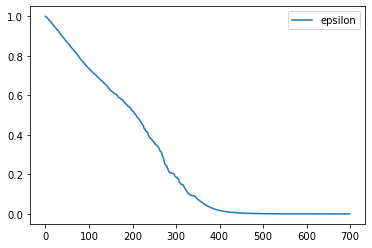

In [15]:
plt.plot(eps, label="epsilon")
plt.legend()
plt.savefig('./plots/torch/epsilon.png')
plt.show()

In [16]:
losses_array = []
for x in losses:
    losses_array.append(np.mean(np.array(x)))

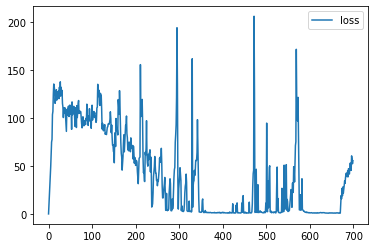

In [17]:
plt.plot(losses_array, label="loss")
plt.legend()
plt.savefig('./plots/torch/losses.png')
plt.show()

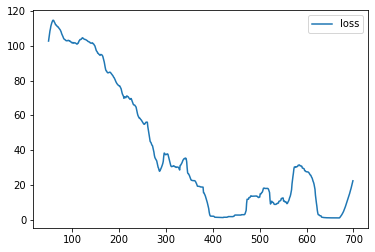

In [18]:
resolution = 50

cumsum_losses = np.array(pd.Series(np.array(losses_array)).rolling(window=resolution).mean() )

plt.plot(cumsum_losses, label="loss")
plt.legend()
plt.savefig('./plots/torch/losses_trend.png')
plt.show()

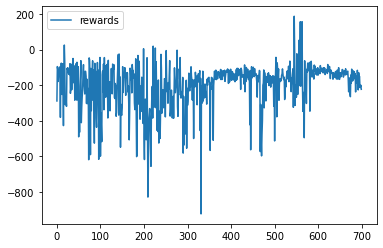

In [19]:
plt.plot(scores, label="rewards")
plt.legend()
plt.savefig('./plots/torch/rewards.png')
plt.show()

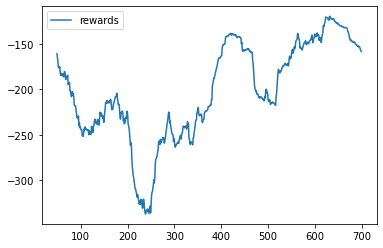

In [20]:
resolution = 50

cumsum_rewards = np.array(pd.Series(np.array(scores)).rolling(window=resolution).mean() )

plt.plot(cumsum_rewards, label="rewards")
plt.legend()
plt.savefig('./plots/torch/rewards_trend.png')
plt.show()

In [21]:
test_env = gym.make('LunarLander-v2')

test_agent = Agent(n_actions=test_env.action_space.n, input_dims=test_env.observation_space.shape)

test_agent.epsilon = 0.0
test_agent.load_model()

In [22]:
test_episodes = 10

pbar = tqdm(range(test_episodes))

for i in pbar:
    done = False
    score = 0
    obs = test_env.reset()
    test_env.render()

    while not(done):
        action = test_agent.choose_action(obs)
        
        new_obs, reward, done, _ = test_env.step(action)
        test_env.render()

        score = score + reward

        obs = deepcopy(new_obs)
    
    scores.append(score)
    pbar.set_description("Current_score = %s" % score)
    print("score in episode ", i ," : ",score)
test_env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

score in episode  0  :  -215.5858939493075
score in episode  1  :  -167.78960671429294
score in episode  2  :  -189.33970694511814
score in episode  3  :  -164.1527624344066
score in episode  4  :  -238.63481727552374
score in episode  5  :  -165.26271856831048
score in episode  6  :  -161.78405132488257
score in episode  7  :  -175.890282072837
score in episode  8  :  -124.1924955489289
score in episode  9  :  -238.30332014556086
